# Is It on Fire?

<img src="images/ap-caldor-fire.jpg" alt="Fire" style="width: 600px;"/>

###### *Source: AP News*

## Problem Statement
Being able to identify a problem situation early can be beneficial and prevent harm.  With all the video and still footage taken by security cameras we can use these images to train a model to automatically detect (classify) situations where everything is fine, where there is smoke or where there is an actual fire.

This type of classification could be applied to many topics, such as which kind of microplastic is in the water, land type use, and identifying invasive species.

For testing this project, you can give it an image and it will determine if it's normal, there's fire or there's smoke.  While you would not want to do that for a lot of images, the idea is that you could build the model with some automation to be able to routinely scan images to detect fire.

***Reproducibility Note: Due to randomness you will probably get different results.***
According to the keras FAQ, if you pass in a numpy array, the default for model.fit() is True, then the training data will be globally randomly shuffled at each epoch.  However, Validation data is never shuffled.

In [2]:
import pandas as pd
import numpy as np
from numpy.random import seed
import os
import shutil
import random

from skimage.io import imread, imshow

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#!pip install tensorflow
#!pip install tensorflow-hub
import tensorflow as tf
from tensorflow import random
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#import tensorflow_hub as hub
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.applications import imagenet_utils

from IPython.display import Image
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='toc'></a>
## Table of Contents

* [Data and Pre-Processing](#data)
   * [Data Pre-Processing](#preprocessing)
   * [Image Exploratory Data Analysis (EDA)](#eda)
   * [ImageDataGenerator](#imagedatagenerator)
* [Build a Basic Model](#model1)
   * [Compile Model](#compilemodel1)
   * [Fit the Model](#fitmodel1)
   * [Model Accuracy and Loss](#accuracymodel1)
   * [Tuning Model 1 - Adjusting the Learning Rate](#tune_lr)
   * [Tuning Model 1 - Change the Optimizer to Adam](#adam)
   * [Tuning Model 1 - Dropout](#tune_dropout)
   * [The Best of Our Basic Model](#bestmodel1)
* [Building Models with More Layers](#layers)
   * [Adam with More Conv2D Layers](#adam_conv2d)
   * [SGD with More Conv2D Layers](#sgd_conv2d)
   * [Adam with More Conv2D and Dense Layers](#adam_dense)
   * [SGD with More Conv2D and Dense Layers](#sgd_dense)
   * [How the Added Layers Are Doing](#layer_results)
* [Using Transfer Learning](#transfer)
   * [Downloading the Classifer from TensorFlow Hub and Pre-Process the Input](#hub)
   * [Compile Model](#compilemodel6)
   * [Train Using the Transfer Model](#trainmodel6)
   * [Model Accuracy and Loss](#accuracymodel6)
* [Model Evaluation and Selection](#evalmodels)
   * [Evaluate the Best Models](#eval)
   * [Pre-Process the Test Data](#preprocesstest)
   * [Evaluate Model on the Test Data](#evaltest)
* [Conclusion](#conclusion)
* [References](#references)

<a class='anchor' id='data'></a>
## Data and Pre-Processing
The original data came from the Fire Detection Dataset by Ritu Pande from Kaggle
https://www.kaggle.com/ritupande/fire-detection-from-cctv

This data is taken from closed circuit tv cameras to determine:
1. things are normal (default) 
2. things are on fire
3. smoke is detected

There are 864 still images.

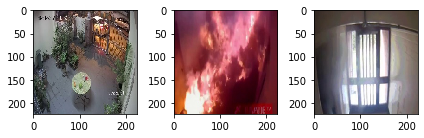

In [3]:
# Based on: https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display
fig = plt.figure()
sample_imgs = ['data/img_data/train/default/img_3.jpg',
               'data/img_data/train/fire/img_88.jpg',
               'data/img_data/train/smoke/img_7.jpg']
num_imgs = len(sample_imgs)
for i in range(num_imgs):
    a=fig.add_subplot(1, num_imgs, i+1)
    image = imread(sample_imgs[i])
    imshow(image)
plt.show();

[Return to TOC](#toc)

<a class='anchor' id='preprocessing'></a>
### Data Pre-Processing 

The data set comes zipped with train and test directories.  We will take the train data and split it 80/20 into train and validation test sets.

Given the stochastic nature of neural nets, which introduce randomness during training, we find that our results will not be the same each time.  Even when setting the numpy seed and the tensorflow seed, I still observed differences in the results each time.

Some of the things that can introduce randomness include:
* differences in the platform (architecture, operating system, math libraries, python version, library version, etc.) you are running on
* stochastic algorithms
* variance in the training data
* randomness in weights
* random shuffling of samples each epoch
* the train-val-test split

**This assumes you ran the 00-prepare-data.py script once before running this notebook or you put 20% of the images in the various validation folders.**

The script randomly selects 20% of the training data and moves it to the validation data directories, but you can just move some files into the validation folders yourself if you want.  

If you do run the script more than once, it will keep moving files from train to val.

In [4]:
seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
base_dir = os.getcwd()

train_dir = base_dir + '/data/img_data/train'
train_dir_default = train_dir + '/default'
train_dir_fire = train_dir + '/fire'
train_dir_smoke = train_dir + '/smoke'

val_dir = base_dir + '/data/img_data/val'
val_dir_default = val_dir + '/default'
val_dir_fire = val_dir + '/fire'
val_dir_smoke = val_dir + '/smoke'

test_dir = base_dir + '/data/img_data/test'
test_dir_default = test_dir + '/default'
test_dir_fire = test_dir + '/fire'
test_dir_smoke = test_dir + '/smoke'

In [6]:
class_nms = ['normal','fire','smoke']

[Return to TOC](#toc)

### Image EDA

Do we have class imbalance?

In [9]:
total_train_imgs = len(os.listdir(train_dir_default)) + len(os.listdir(train_dir_fire)) + len(os.listdir(train_dir_smoke))
total_val_imgs = len(os.listdir(val_dir_default)) + len(os.listdir(val_dir_fire)) + len(os.listdir(val_dir_smoke))
total_test_imgs = len(os.listdir(test_dir_default)) + len(os.listdir(test_dir_fire)) + len(os.listdir(test_dir_smoke))

print('Number of default training images:', len(os.listdir(train_dir_default)), '(', (round(len(os.listdir(train_dir_default))/total_train_imgs, 2)*100),'% )')
print('Number of fire training images:', len(os.listdir(train_dir_fire)),'(', (round(len(os.listdir(train_dir_fire))/total_train_imgs, 2)*100),'% )')
print('Number of smoke training images:', len(os.listdir(train_dir_smoke)), '(', (round(len(os.listdir(train_dir_smoke))/total_train_imgs, 2)*100),'% )')
print()
print('Number of default val images:', len(os.listdir(val_dir_default)), '(', (round(len(os.listdir(val_dir_default))/total_val_imgs, 2)*100),'% )')
print('Number of fire val images:', len(os.listdir(val_dir_fire)), '(', (round(len(os.listdir(val_dir_fire))/total_val_imgs, 2)*100),'% )')
print('Number of smoke val images:', len(os.listdir(val_dir_smoke)), '(', (round(len(os.listdir(val_dir_smoke))/total_val_imgs, 2)*100),'% )')
print()
print('Number of default test images:', len(os.listdir(test_dir_default)), '(', (round(len(os.listdir(test_dir_default))/total_test_imgs, 2)*100),'% )')
print('Number of fire test images:', len(os.listdir(test_dir_fire)), '(', (round(len(os.listdir(test_dir_fire))/total_test_imgs, 2)*100),'% )')
print('Number of smoke test images:', len(os.listdir(test_dir_smoke)), '(', (round(len(os.listdir(test_dir_smoke))/total_test_imgs, 2)*100),'% )')

Number of default training images: 129 ( 23.0 % )
Number of fire training images: 220 ( 40.0 % )
Number of smoke training images: 207 ( 37.0 % )

Number of default val images: 32 ( 23.0 % )
Number of fire val images: 54 ( 39.0 % )
Number of smoke val images: 51 ( 37.0 % )

Number of default test images: 84 ( 49.0 % )
Number of fire test images: 57 ( 33.0 % )
Number of smoke test images: 30 ( 18.0 % )


**Observation:** We have a pretty balanced data set.

In [10]:
num_train_classes = {'Default': len(os.listdir(train_dir_default)),
                     'Fire': len(os.listdir(train_dir_fire)),
                     'Smoke': len(os.listdir(train_dir_smoke))}

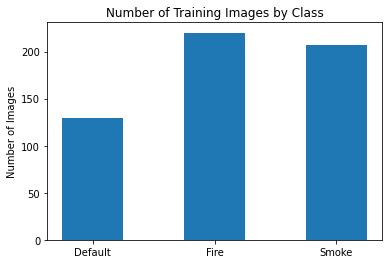

In [11]:
plt.bar(num_train_classes.keys(), num_train_classes.values(), width=.5);
plt.title('Number of Training Images by Class');
plt.xlabel('');
plt.ylabel('Number of Images');

In [12]:
num_val_classes = {'Default': len(os.listdir(val_dir_default)),
                   'Fire': len(os.listdir(val_dir_fire)),
                   'Smoke': len(os.listdir(val_dir_smoke))}

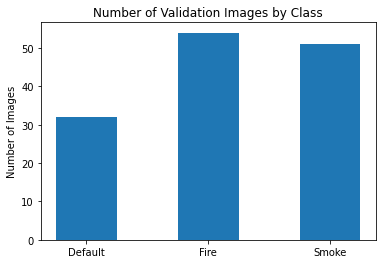

In [13]:
plt.bar(num_val_classes.keys(), num_val_classes.values(), width=.5);
plt.title('Number of Validation Images by Class');
plt.xlabel('');
plt.ylabel('Number of Images');

### Average File Size

In [14]:
print('Average training default file size: ',  round(os.stat(train_dir_default).st_size/len(os.listdir(train_dir_default))), 'KB')
print('Average training fire file size: ',  round(os.stat(train_dir_fire).st_size/len(os.listdir(train_dir_fire))), 'KB')
print('Average training smoke file size: ',  round(os.stat(train_dir_smoke).st_size/len(os.listdir(train_dir_smoke))), 'KB')
print()
print('Average validation default file size: ',  round(os.stat(val_dir_default).st_size/len(os.listdir(val_dir_default))), 'KB')
print('Average validation fire file size: ',  round(os.stat(val_dir_fire).st_size/len(os.listdir(val_dir_fire))), 'KB')
print('Average validation smoke file size: ',  round(os.stat(val_dir_smoke).st_size/len(os.listdir(val_dir_smoke))), 'KB')

Average training default file size:  32 KB
Average training fire file size:  32 KB
Average training smoke file size:  32 KB

Average validation default file size:  34 KB
Average validation fire file size:  33 KB
Average validation smoke file size:  33 KB


### Image Size

In [15]:
im = Image.open('data/img_data/train/fire/img_88.jpg')
print('width: ', im.width)
print('height:', im.height)

width:  224
height: 224


**Observations:** 
* We have a pretty standard size images to work with.
* Even though some photos are labeled (2), they are not actually duplicates. (Determined by visual inspection)

[Return to TOC](#toc)

<a class='anchor' id='imagedatagenerator'></a>
### [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) - Real-Time Data Augmentation

This helps to process our data in the various category folders quickly.  We could also vary things like rotation, flipping vertically or horizontally, shifting, brightening, or zooming in or out on an image to augment them during the pre-processing and training process.  For our base model, we will only rescale the images  to pixel values from [0,255] (256 colors) to [0,1] to normalize them.  This reduces the amount of information and stores all the images as the same size.

In [16]:
# parameters for the ImageDataGenerator
BATCH_SIZE = 10
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 556 images belonging to 3 classes.


In [18]:
val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

Found 137 images belonging to 3 classes.


In [19]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (10, 224, 224, 3)
labels batch shape: (10, 3)


[Return to TOC](#toc)

<a class='anchor' id='model1'></a>
## Build a Basic [Neural Net](https://en.wikipedia.org/wiki/Artificial_neural_network) Model (Model 1)
For this model, we kept it simple.  We only rescaled the images to go from 256 colors to a range between 0 and 1 and we did not use any extra augmentations. Only a few basic layers were used in the model:

### [Convolutional 2D Layer](https://keras.io/api/layers/convolution_layers/convolution2d/)
A filter or kernel that moves over the 2 dimensional input data to perform elementwise multiplication to create a feature map.
<img src="https://machinelearningmastery.com/wp-content/uploads/2019/01/Example-of-a-Filter-Applied-to-a-Two-Dimensional-input-to-create-a-Feature-Map.png" width="300" height="300">

*Source: https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/*

### [Max 2D Pooling Layer](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
A layer that helps to downsample the input by taking the maximum value over an input window for each channel of the input.
<img src="https://miro.medium.com/max/1400/1*sq6uZmuFiQGcXVZFcZK1vg.png" width="600" height="400">
* Source: https://medium.com/geekculture/max-pooling-why-use-it-and-its-advantages-5807a0190459*

### [Dense Layers](https://keras.io/api/layers/core_layers/dense/)
A fully connected layer, meaning each node is connected to each node in the previous layer, to which it applies weights.
<img src="images/Dense-Layer-in-Keras-df.jpg" width="800" height="400">
 
*Source: https://data-flair.training/blogs/keras-convolution-neural-network/*

### [Activation Functions](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)
Activation functions are applied to the hidden layers and the output layer of a neural network. They determine how the input layer is mapped to the output layer.  

**[ReLU Activation](https://keras.io/api/layers/activation_layers/relu/)**
One of the most common for hidden layers is the rectified linear activation function (**ReLU**), a piecewise linear function that is the input is positive, returns that positive value and if it is negative, returns 0.  This is typically the default activation function for convolutional neural networks.

<img src="https://machinelearningmastery.com/wp-content/uploads/2020/12/Plot-of-Inputs-vs-Outputs-for-the-ReLU-Activation-Function..png" width="300" height="300">
 
*Source: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/*

**[Softmax](https://machinelearningmastery.com/softmax-activation-function-with-python/)**

The softmax function outputs a vector of values that sum to 1.0.  We can interpret these as the probabilities that the classification is in a particular category.  This is typically used when there are more than 2 classification categories.

<img src="images/softmax-in-cnn.png" width="600" height="300">

*Source: https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d*
*Original: *

In [20]:
# model parameters
BATCH_SIZE = 10    # how many images to process in each batch
IMG_CHANNELS = 3   # how many channels (Red Green Blue = RGB)
EPOCHS = 10        # how many times we want to pass over the all the training data
STEP_SIZE = 10     # number of steps

Function to create a basic model, where we can change:
* image height 
* image width
* number of image channels
* optimizer
* learning rate
* momentum

In [21]:
def create_model(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS, optimizer='Adam', lr=0.001, momentum=0.8):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())                       # this converts it a vector 1D
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    if optimizer == 'SGD':
        optimizer=optimizers.SGD(learning_rate=lr, momentum=momentum)
    else:
        optimizer=optimizers.Adam(learning_rate=lr)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    
    return model

[Return to TOC](#toc)

<a class='anchor' id='compilemodel1'></a>
### Compile Model 1

When creating a model we are trying to optimize (minimize loss or cost) over our objective function. When compiling the model we can specify out optimzer, our loss function, how fast the model learns (learning rate), what metrics we wish to measure.

#### [Stochastic Gradient Descent](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31)

We used Stochastic Gradient Descent (SGD), which adds a bit of randomization, as our optimizer. We are trying to find a global minimum.  Think of it as descending a mountain to get to the lowest point, but there may be obstacles in the way, such as a tree, so you might take a slightly random way down (see the purple in the image below). 

Default parameters for SGD are learning_rate=0.01, momentum=0.0, decay=0.0.

<img src="https://imaddabbura.github.io/img/gradient-descent-algorithms/batch-vs-minibatch-vs-stochastic.PNG" width="400" height="400">

*Source: https://imaddabbura.github.io/post/gradient-descent-algorithm/*

#### [Loss Functions](https://algorithmia.com/blog/introduction-to-loss-functions)

Since we have 3 classes (normal/default, fire, smoke), we used **[categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)** for our loss function, to predict the probability of the image belonging to one class or another.  Typically, you find softmax and categorical_crossentropy used together for multiclass classification problems.

The **[learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)** is how much to change the model in response to the estimated error when the model weights are updated.  If it is too small, it can take forever to train the model.  If it is too large, you may skip over the global minimum. 

**[Momentum](https://kyle-r-kieser.medium.com/tuning-your-keras-sgd-neural-network-optimizer-768536c7ef0)** accelerates the gradient descent in the relevant direction and dampens oscillations.

In [22]:
model1 = create_model(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS, 
                      optimizer='SGD', lr=0.001, momentum=0.8)

<a class='anchor' id='fitmodel1'></a>
### Fit Model 1

Now that we have specified the model and told it what we want to optimize and how, we are ready to train the model.  We are going to use 10 steps for each epoch over both the training and the validation data.  We are using our ImageDataGenerators previously specified. 

In [23]:
history1 = model1.fit(train_generator,
                      steps_per_epoch=STEP_SIZE,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data=validation_generator,
                      validation_steps=STEP_SIZE)

Epoch 1/10
10/10 [==============================] - 2s 188ms/step - loss: 1.0790 - acc: 0.3700 - val_loss: 1.7318 - val_acc: 0.1400
Epoch 2/10
10/10 [==============================] - 2s 178ms/step - loss: 1.1218 - acc: 0.4100 - val_loss: 1.0991 - val_acc: 0.3900
Epoch 3/10
10/10 [==============================] - 2s 185ms/step - loss: 1.0957 - acc: 0.4000 - val_loss: 1.0887 - val_acc: 0.5300
Epoch 4/10
10/10 [==============================] - 2s 182ms/step - loss: 1.0615 - acc: 0.5200 - val_loss: 1.0866 - val_acc: 0.5500
Epoch 5/10
10/10 [==============================] - 2s 198ms/step - loss: 1.0278 - acc: 0.4688 - val_loss: 1.0939 - val_acc: 0.4700
Epoch 6/10
10/10 [==============================] - 2s 188ms/step - loss: 1.0032 - acc: 0.5800 - val_loss: 1.0966 - val_acc: 0.4400
Epoch 7/10
10/10 [==============================] - 2s 187ms/step - loss: 1.0041 - acc: 0.5521 - val_loss: 1.0969 - val_acc: 0.4500
Epoch 8/10
10/10 [==============================] - 2s 198ms/step - loss: 0.

[Return to TOC](#toc)

<a class='anchor' id='accuracymodel1'></a>
### Model 1 Accuracy and Loss

How accurate our predictions are compared to the actual data.
How well the model is doing after each iteration of optimization (i.e., model error).

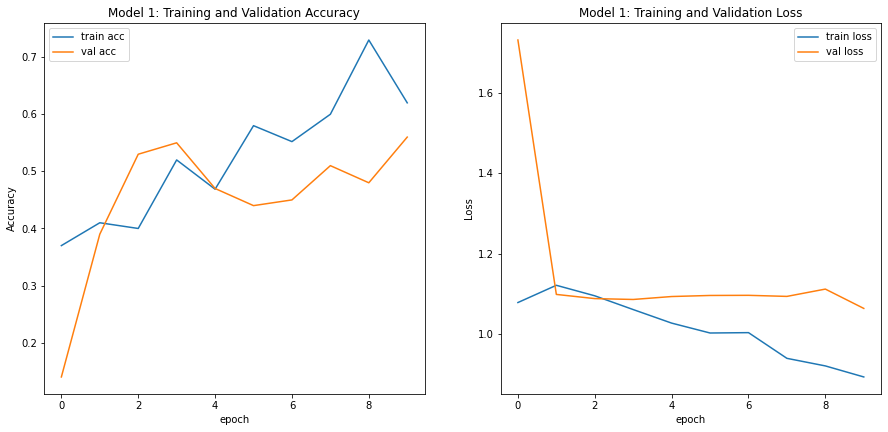

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(history1.history['acc'], label='train acc')
plt.plot(history1.history['val_acc'], label='val acc')
plt.title('Model 1: Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.title('Model 1: Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [25]:
print('Model 1 - SGD with learning_rate = 0.2 and momentum = 0.8')
print('Median Training Accuracy: ', np.median(history1.history['acc']))
print('Standard Deviation Training Loss: ', np.std(history1.history['loss']))
print('Median Validation Accuracy: ', np.median(history1.history['val_acc']))
print('Standard Deviation Validation Loss: ', np.std(history1.history['val_loss']))

Model 1 - SGD with learning_rate = 0.2 and momentum = 0.8
Median Training Accuracy:  0.536041647195816
Standard Deviation Training Loss:  0.07323301189318532
Median Validation Accuracy:  0.4749999940395355
Standard Deviation Validation Loss:  0.19212662550498097


In [26]:
model1.save('models/model1-base')

[Return to TOC](#toc)

<a class='anchor' id='tune_lr'></a>
### Model 1 - Adjusting the Learning Rate

In [27]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print('Testing with learning rate =', lr, 'optimizer = SGD')
    model = create_model(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS, 
                         optimizer='SGD', lr=lr, momentum=0.8)
    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE,
                        verbose=0
                       )
    scores[lr] = history.history
    filename = "models/model1-base-SGD-{0}".format(lr)
    model.save(filename)
    print()

Testing with learning rate = 0.0001 optimizer = SGD

Testing with learning rate = 0.001 optimizer = SGD

Testing with learning rate = 0.01 optimizer = SGD

Testing with learning rate = 0.1 optimizer = SGD



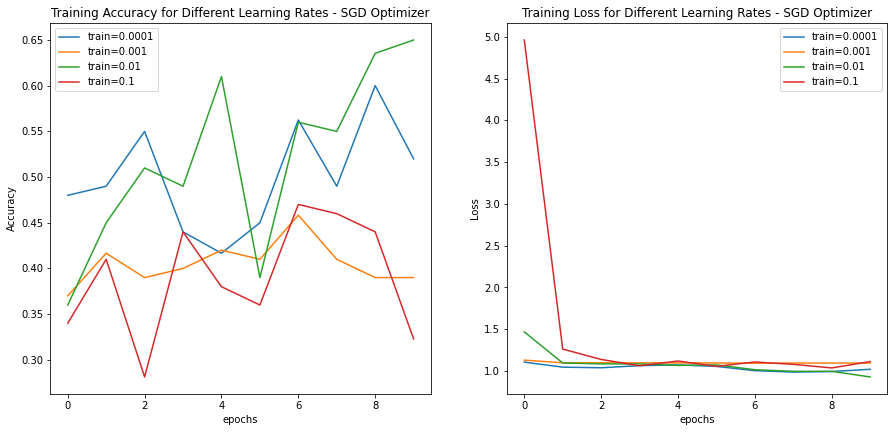

In [28]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
for lr, hist in scores.items():
    plt.plot(hist['acc'], label=('train=%s' % lr))           
plt.title('Training Accuracy for Different Learning Rates - SGD Optimizer')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend();

plt.subplot(2,2,2)
for lr, hist in scores.items():
    plt.plot(hist['loss'], label=('train=%s' % lr))           
plt.title('Training Loss for Different Learning Rates - SGD Optimizer')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend();
plt.show();

<a class='anchor' id='fitmodel2'></a>

[Return to TOC](#toc)

<a class='anchor' id='adam'></a>
### Tuning Model 1 - Changing the Optimizer to Adam
Adaptive Moment Estimation (Adam) is built on SGD.  It uses adaptive estimation of first-order and second-order moments used to calculate the mean and variance of a tensor, a generalization of a matrices in higher dimension, to converge faster.

*Note: momentum is not a parameter that can be tuned for the Adam optimizer.*

In [29]:
scores2 = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print('Testing with learning rate =', lr, 'optimizer = Adam')
    model = create_model(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS, 
                         optimizer='Adam', lr=lr, momentum=0.0)
    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE,
                        verbose=0
                       )
    scores2[lr] = history.history
    filename = "models/model1-base-Adam-{0}".format(lr)
    model.save(filename)
    print()

Testing with learning rate = 0.0001 optimizer = Adam

Testing with learning rate = 0.001 optimizer = Adam

Testing with learning rate = 0.01 optimizer = Adam

Testing with learning rate = 0.1 optimizer = Adam



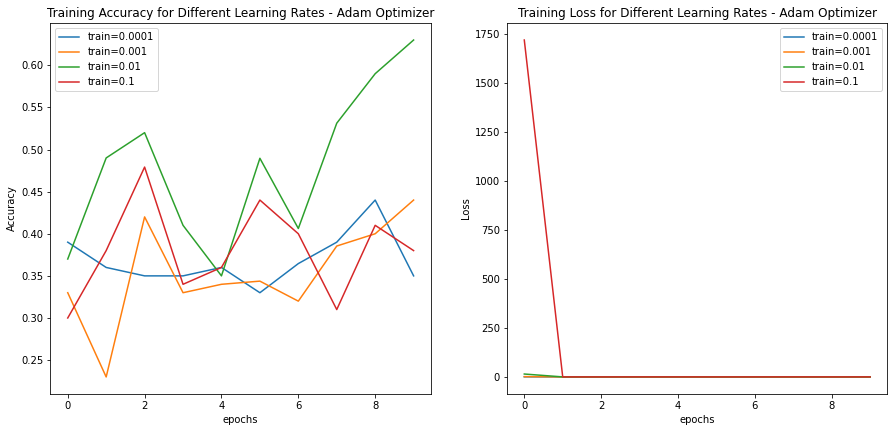

In [30]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
for lr, hist in scores2.items():
    plt.plot(hist['acc'], label=('train=%s' % lr))           
plt.title('Training Accuracy for Different Learning Rates - Adam Optimizer')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
for lr, hist in scores2.items():
    plt.plot(hist['loss'], label=('train=%s' % lr))           
plt.title('Training Loss for Different Learning Rates - Adam Optimizer')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

[Return to TOC](#toc)

<a class='anchor' id='tune_dropout'></a>
### Tuning Model 1 - Dropout
Trying different dropout rates using a learning rate of 0.001.

In [31]:
def create_drop_model(learning_rate=0.001, optimizer='SGD', droprate=0.0, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())                       
    model.add(layers.Dense(6, activation='relu'))
    model.add(layers.Dropout(droprate))   
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    return model

In [32]:
scores3 = {}

for dr in [0.0, 0.2, 0.5, 0.8]:
    print('Testing with dropout rate =', dr, 'optimizer = SGD')
    model = create_drop_model(droprate=dr)
    history = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE,
                        verbose=0)
    scores3[dr] = history.history
    filename = "models/model1-base-SGD-dropout-{0}".format(dr)
    model.save(filename)
    print()

Testing with dropout rate = 0.0 optimizer = SGD

Testing with dropout rate = 0.2 optimizer = SGD

Testing with dropout rate = 0.5 optimizer = SGD

Testing with dropout rate = 0.8 optimizer = SGD



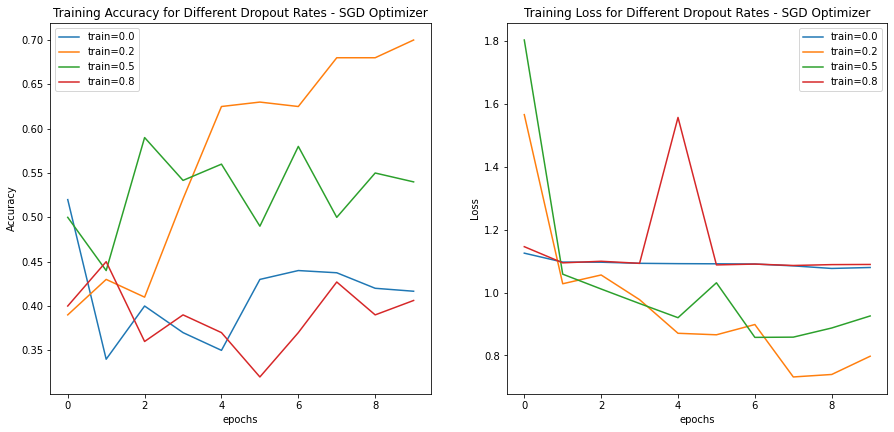

In [33]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
for dr, hist in scores3.items():
    plt.plot(hist['acc'], label=('train=%s' % dr))           
plt.title('Training Accuracy for Different Dropout Rates - SGD Optimizer')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
for dr, hist in scores3.items():
    plt.plot(hist['loss'], label=('train=%s' % dr))           
plt.title('Training Loss for Different Dropout Rates - SGD Optimizer')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

[Return to TOC](#toc)

<a class='anchor' id='bestmodel1'></a>
### The Best of Our Basic Model
Here's how we are doing so far with our models:

In [34]:
data = {
    'model_nm':['SGD - learning rate = 0.2, momentum = 0.8',
                'SGD - learning rate = 0.0001',
                'SGD - learning rate = 0.001',
                'SGD - learning rate = 0.01',
                'SGD - learning rate = 0.1',
                'Adam - learning rate = 0.0001',
                'Adam - learning rate = 0.001',
                'Adam - learning rate = 0.01',
                'Adam - learning rate = 0.1',
                'SGD - dropout = 0.0',
                'SGD - dropout = 0.2',
                'SGD - dropout = 0.5',
                'SGD - dropout = 0.8'],
    'median_train_acc':[np.median(history1.history['acc']),
                        np.median(scores[0.0001]['acc']),
                        np.median(scores[0.001]['acc']),          
                        np.median(scores[0.01]['acc']),
                        np.median(scores[0.1]['acc']),
                        np.median(scores2[0.0001]['acc']),
                        np.median(scores2[0.001]['acc']),
                        np.median(scores2[0.01]['acc']),
                        np.median(scores2[0.1]['acc']),
                        np.median(scores3[0.0]['acc']),
                        np.median(scores3[0.2]['acc']),
                        np.median(scores3[0.5]['acc']),
                        np.median(scores3[0.8]['acc'])],
    'std_dev_train_loss':[np.std(history1.history['loss']),
                          np.std(scores[0.0001]['loss']),
                          np.std(scores[0.001]['loss']),
                          np.std(scores[0.01]['loss']),
                          np.std(scores[0.1]['loss']),
                          np.std(scores2[0.0001]['loss']),
                          np.std(scores2[0.001]['loss']),
                          np.std(scores2[0.01]['loss']),
                          np.std(scores2[0.1]['loss']),
                          np.std(scores3[0.0]['loss']),
                          np.std(scores3[0.2]['loss']),
                          np.std(scores3[0.5]['loss']),
                          np.std(scores3[0.8]['loss'])],
    'median_val_acc':[np.median(history1.history['val_acc']),
                      np.median(scores[0.0001]['val_acc']),
                      np.median(scores[0.001]['val_acc']),
                      np.median(scores[0.01]['val_acc']),
                      np.median(scores[0.1]['val_acc']),
                      np.median(scores2[0.0001]['val_acc']),
                      np.median(scores2[0.001]['val_acc']),
                      np.median(scores2[0.01]['val_acc']),
                      np.median(scores2[0.1]['val_acc']),
                      np.median(scores3[0.0]['val_acc']),
                      np.median(scores3[0.2]['val_acc']),
                      np.median(scores3[0.5]['val_acc']),
                      np.median(scores3[0.8]['val_acc'])],
     'std_dev_val_loss':[np.std(history1.history['val_loss']),
                         np.std(scores[0.0001]['val_loss']),
                         np.std(scores[0.001]['val_loss']),
                         np.std(scores[0.01]['val_loss']),
                         np.std(scores[0.1]['val_loss']),
                         np.std(scores2[0.0001]['val_loss']),
                         np.std(scores2[0.001]['val_loss']),
                         np.std(scores2[0.01]['val_loss']),
                         np.std(scores2[0.1]['val_loss']),
                         np.std(scores3[0.0]['val_loss']),
                         np.std(scores3[0.2]['val_loss']),
                         np.std(scores3[0.5]['val_loss']),
                         np.std(scores3[0.8]['val_loss'])]
    }
    
df = pd.DataFrame(data) 

In [35]:
df.sort_values('median_val_acc', ascending=False)

,model_nm,median_train_acc,std_dev_train_loss,median_val_acc,std_dev_val_loss
10,SGD - dropout = 0.2,0.625000,0.230028,0.730,0.181499
11,SGD - dropout = 0.5,0.540833,0.265785,0.605,0.082236
3,SGD - learning rate = 0.01,0.530000,0.138835,0.600,0.094126
7,Adam - learning rate = 0.01,0.489792,4.431596,0.560,0.025022
2,SGD - learning rate = 0.001,0.405000,0.010283,0.540,0.002131
4,SGD - learning rate = 0.1,0.395000,1.157958,0.540,0.047417
9,SGD - dropout = 0.0,0.418333,0.012612,0.540,0.006482
1,SGD - learning rate = 0.0001,0.490000,0.036005,0.530,0.040923
0,"SGD - learning rate = 0.2, momentum = 0.8",0.536042,0.073233,0.475,0.192127
6,Adam - learning rate = 0.001,0.341875,0.420410,0.430,0.000723


**Observations:**
I have noticed that each time, we run the code, different models could have the highest median validation accuracy.

There are many more hyperparameters that we could vary, but we will stop here due to the limited time available for this project.

***Note: Due to the stochastic nature of neural nets, your results may differ.***

[Return to TOC](#toc)

<a class='anchor' id='layers'></a>
## Building Models with More Layers

We will try adding in more layers to see if we get better results.  

The process of determining how many layers and which works best is a bit trial and error.  Normally, we would want to run a lot of experiements and see how they do, but we have limited time, so we will just try a few.

* Model 2 - Adam with more Conv2D layers (than Model 1)
* Model 3 - SGD with more Conv2D layers
* Model 4 - Adam with more Conv2D and Dense layers
* Model 5 - SGD with more Conv2D and Dense layers

<a class='anchor' id='adam_conv2d'></a>
#### Adding More Convolutional Layers

We are increasing the number of filters in the convolutional 2D layers to increase the size of the feature map.  Typically fewer filters are used at the input layer and more filters are used in deeper layers.

In [36]:
def create_model_with_more_conv_layers(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS, 
                                       optimizer='Adam', lr=0.001, momentum=0.8):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(3, activation='softmax'))
    
    if optimizer == 'SGD':
        optimizer=optimizers.SGD(learning_rate=lr, momentum=momentum)
    else:
        optimizer=optimizers.Adam(learning_rate=lr)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    
    return model

In [37]:
model2 = create_model_with_more_conv_layers(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, optimizer='Adam', lr=0.001, momentum=0.0)

In [38]:
history2 = model2.fit(train_generator,
                      steps_per_epoch=STEP_SIZE,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data=validation_generator,
                      validation_steps=STEP_SIZE)

Epoch 1/10
10/10 [==============================] - 17s 2s/step - loss: 1.1512 - acc: 0.4100 - val_loss: 1.0806 - val_acc: 0.5400
Epoch 2/10
10/10 [==============================] - 15s 2s/step - loss: 1.1051 - acc: 0.3600 - val_loss: 1.0869 - val_acc: 0.4300
Epoch 3/10
10/10 [==============================] - 16s 2s/step - loss: 1.0274 - acc: 0.4500 - val_loss: 0.9449 - val_acc: 0.5700
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 1.0247 - acc: 0.4800 - val_loss: 1.0553 - val_acc: 0.6000
Epoch 5/10
10/10 [==============================] - 14s 1s/step - loss: 0.9122 - acc: 0.5700 - val_loss: 0.8330 - val_acc: 0.7100
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 0.7399 - acc: 0.7200 - val_loss: 0.7572 - val_acc: 0.7800
Epoch 7/10
10/10 [==============================] - 14s 1s/step - loss: 0.8368 - acc: 0.6900 - val_loss: 0.9552 - val_acc: 0.6000
Epoch 8/10
10/10 [==============================] - 14s 1s/step - loss: 0.9375 - acc: 0.60

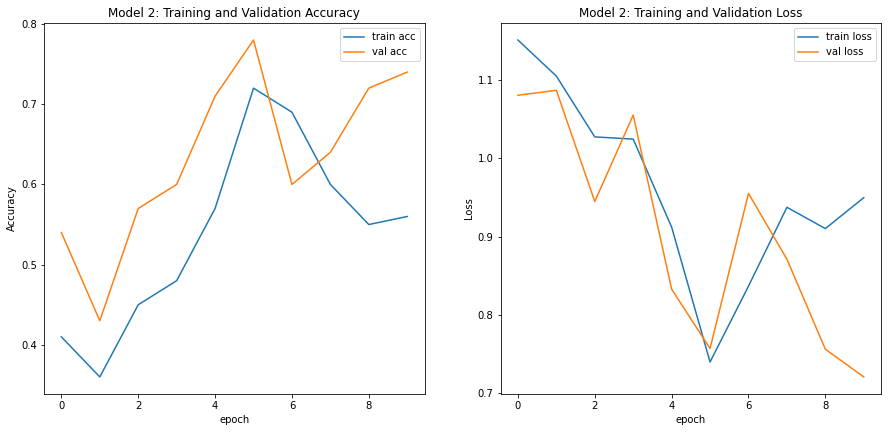

In [39]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(history2.history['acc'], label='train acc')
plt.plot(history2.history['val_acc'], label='val acc')
plt.title('Model 2: Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.title('Model 2: Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [40]:
print('Model 2 - More Conv2D Layers - Adam with learning_rate = 0.001')
print('Median Training Accuracy: ', np.median(history2.history['acc']))
print('Standard Deviation Training Loss: ', np.std(history2.history['loss']))
print('Median Validation Accuracy: ', np.median(history2.history['val_acc']))
print('Standard Deviation Validation Loss: ', np.std(history2.history['val_loss']))

Model 2 - More Conv2D Layers - Adam with learning_rate = 0.001
Median Training Accuracy:  0.5550000071525574
Standard Deviation Training Loss:  0.11632529031821615
Median Validation Accuracy:  0.6200000047683716
Standard Deviation Validation Loss:  0.13224207897196338


In [41]:
model2.save('models/model2-adam-convs')

[Return to TOC](#toc)

<a class='anchor' id='sgd_conv2d'></a>
#### Switching to SGD Optimizer

In [42]:
model3 = create_model_with_more_conv_layers(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, optimizer='SGD', lr=0.001, momentum=0.8)

In [43]:
history3 = model3.fit(train_generator,
                      steps_per_epoch=STEP_SIZE,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data=validation_generator,
                      validation_steps=STEP_SIZE)

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 1.1013 - acc: 0.3646 - val_loss: 1.0894 - val_acc: 0.5400
Epoch 2/10
10/10 [==============================] - 15s 1s/step - loss: 1.0829 - acc: 0.4700 - val_loss: 1.0761 - val_acc: 0.5400
Epoch 3/10
10/10 [==============================] - 14s 1s/step - loss: 1.1024 - acc: 0.3500 - val_loss: 1.1005 - val_acc: 0.2800
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 1.0673 - acc: 0.4700 - val_loss: 1.0460 - val_acc: 0.5400
Epoch 5/10
10/10 [==============================] - 14s 1s/step - loss: 1.0083 - acc: 0.5000 - val_loss: 1.0397 - val_acc: 0.5600
Epoch 6/10
10/10 [==============================] - 16s 2s/step - loss: 1.0288 - acc: 0.5100 - val_loss: 1.0538 - val_acc: 0.4700
Epoch 7/10
10/10 [==============================] - 14s 1s/step - loss: 1.0096 - acc: 0.4900 - val_loss: 1.0515 - val_acc: 0.4500
Epoch 8/10
10/10 [==============================] - 16s 2s/step - loss: 0.9237 - acc: 0.61

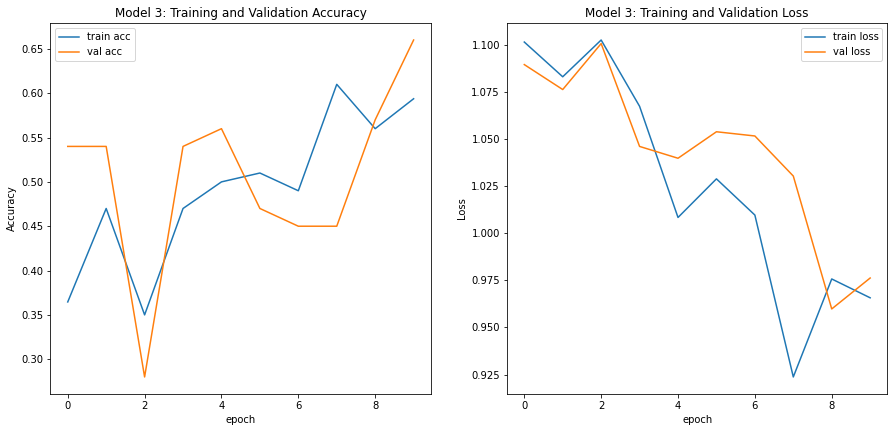

In [44]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(history3.history['acc'], label='train acc')
plt.plot(history3.history['val_acc'], label='val acc')
plt.title('Model 3: Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.title('Model 3: Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [45]:
print('Model 3 - More Conv2D Layers - SGD with learning_rate = 0.001')
print('Median Training Accuracy: ', np.median(history2.history['acc']))
print('Standard Deviation Training Loss: ', np.std(history2.history['loss']))
print('Median Validation Accuracy: ', np.median(history2.history['val_acc']))
print('Standard Deviation Validation Loss: ', np.std(history2.history['val_loss']))

Model 3 - More Conv2D Layers - SGD with learning_rate = 0.001
Median Training Accuracy:  0.5550000071525574
Standard Deviation Training Loss:  0.11632529031821615
Median Validation Accuracy:  0.6200000047683716
Standard Deviation Validation Loss:  0.13224207897196338


In [46]:
model3.save('models/model3-sgd-convs')

[Return to TOC](#toc)

<a class='anchor' id='adam_dense'></a>
#### Adding More Dense (Hidden) Layers

In [47]:
def create_model_with_more_dense_layers(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=IMG_CHANNELS, 
                                        optimizer='Adam', lr=0.001, momentum=0.8):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(3, activation='softmax'))
    
    if optimizer == 'SGD':
        optimizer=optimizers.SGD(learning_rate=lr, momentum=momentum)
    else:
        optimizer=optimizers.Adam(learning_rate=lr)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    
    return model

In [48]:
model4 = create_model_with_more_dense_layers(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, optimizer='Adam', lr=0.001, momentum=0.8)

In [49]:
history4 = model4.fit(train_generator,
                      steps_per_epoch=STEP_SIZE,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data=validation_generator,
                      validation_steps=STEP_SIZE)

Epoch 1/10
10/10 [==============================] - 15s 2s/step - loss: 1.3633 - acc: 0.4167 - val_loss: 1.0942 - val_acc: 0.5100
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 1.0671 - acc: 0.4500 - val_loss: 1.0940 - val_acc: 0.5400
Epoch 3/10
10/10 [==============================] - 15s 2s/step - loss: 1.0317 - acc: 0.5200 - val_loss: 1.0859 - val_acc: 0.5100
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 1.0473 - acc: 0.4700 - val_loss: 1.0595 - val_acc: 0.6000
Epoch 5/10
10/10 [==============================] - 15s 1s/step - loss: 0.9970 - acc: 0.5200 - val_loss: 0.9978 - val_acc: 0.5700
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 0.8391 - acc: 0.6100 - val_loss: 0.9998 - val_acc: 0.5000
Epoch 7/10
10/10 [==============================] - 17s 2s/step - loss: 1.0156 - acc: 0.5900 - val_loss: 1.0338 - val_acc: 0.5700
Epoch 8/10
10/10 [==============================] - 15s 2s/step - loss: 0.8968 - acc: 0.60

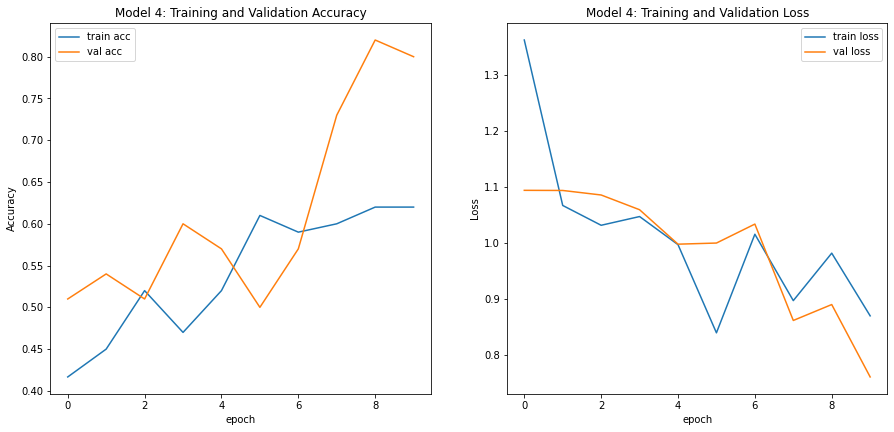

In [50]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(history4.history['acc'], label='train acc')
plt.plot(history4.history['val_acc'], label='val acc')
plt.title('Model 4: Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.title('Model 4: Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [51]:
print('Model 4 - More Dense Layers - Adam with learning_rate = 0.001')
print('Median Training Accuracy: ', np.median(history4.history['acc']))
print('Standard Deviation Training Loss: ', np.std(history4.history['loss']))
print('Median Validation Accuracy: ', np.median(history4.history['val_acc']))
print('Standard Deviation Validation Loss: ', np.std(history4.history['val_loss']))

Model 4 - More Dense Layers - Adam with learning_rate = 0.001
Median Training Accuracy:  0.554999977350235
Standard Deviation Training Loss:  0.13882897227810478
Median Validation Accuracy:  0.5699999928474426
Standard Deviation Validation Loss:  0.10825604227415506


In [52]:
model4.save('models/model4-adam-dense')

[Return to TOC](#toc)

<a class='anchor' id='sgd_dense'></a>
#### Switching to SGD Optimizer

In [53]:
model5 = create_model_with_more_dense_layers(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, optimizer='SGD', lr=0.001, momentum=0.8)

In [54]:
history5 = model5.fit(train_generator,
                      steps_per_epoch=STEP_SIZE,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data=validation_generator,
                      validation_steps=STEP_SIZE)

Epoch 1/10
10/10 [==============================] - 16s 2s/step - loss: 1.0894 - acc: 0.4200 - val_loss: 1.1064 - val_acc: 0.1500
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 1.0856 - acc: 0.4200 - val_loss: 1.0892 - val_acc: 0.5700
Epoch 3/10
10/10 [==============================] - 13s 1s/step - loss: 1.0886 - acc: 0.4583 - val_loss: 1.0878 - val_acc: 0.5900
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 1.0517 - acc: 0.5000 - val_loss: 1.1107 - val_acc: 0.1600
Epoch 5/10
10/10 [==============================] - 16s 2s/step - loss: 1.0837 - acc: 0.4500 - val_loss: 1.0885 - val_acc: 0.4700
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 1.0444 - acc: 0.5500 - val_loss: 1.0726 - val_acc: 0.5800
Epoch 7/10
10/10 [==============================] - 15s 2s/step - loss: 1.0210 - acc: 0.5000 - val_loss: 1.0663 - val_acc: 0.5300
Epoch 8/10
10/10 [==============================] - 16s 2s/step - loss: 1.0453 - acc: 0.48

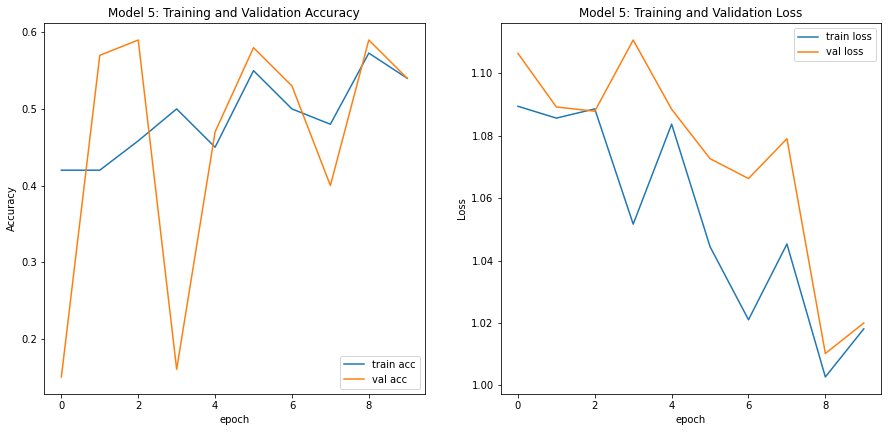

In [55]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(history5.history['acc'], label='train acc')
plt.plot(history5.history['val_acc'], label='val acc')
plt.title('Model 5: Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='val loss')
plt.title('Model 5: Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [56]:
print('Model 5 - More Dense Layers - SGD with learning_rate = 0.001')
print('Median Training Accuracy: ', np.median(history5.history['acc']))
print('Standard Deviation Training Loss: ', np.std(history5.history['loss']))
print('Median Validation Accuracy: ', np.median(history5.history['val_acc']))
print('Standard Deviation Validation Loss: ', np.std(history5.history['val_loss']))

Model 5 - More Dense Layers - SGD with learning_rate = 0.001
Median Training Accuracy:  0.48999999463558197
Standard Deviation Training Loss:  0.030845379922519057
Median Validation Accuracy:  0.5349999964237213
Standard Deviation Validation Loss:  0.03178042934049666


In [57]:
model5.save('models/model5-sgd-dense')

[Return to TOC](#toc)

<a class='anchor' id='layer_results'></a>
### How the Additional Layers Are Doing

In [58]:
data2 = {
    'model_nm':['Adam with more Conv2D layers',
                'SGD with more Conv2D layers',
                'Adam with more Conv2D and Dense layers',
                'SGD with more Conv2D and Dense layers'],
    'median_train_acc':[np.median(history2.history['acc']),
                        np.median(history3.history['acc']),
                        np.median(history4.history['acc']),          
                        np.median(history4.history['acc'])],
    'std_dev_train_loss':[np.std(history2.history['loss']),
                          np.std(history3.history['loss']),
                          np.std(history4.history['loss']),
                          np.std(history5.history['loss'])],
    'median_val_acc':[np.median(history2.history['val_acc']),
                      np.median(history3.history['val_acc']),
                      np.median(history4.history['val_acc']),
                      np.median(history5.history['val_acc'])],
     'std_dev_val_loss':[np.std(history2.history['val_loss']),
                         np.std(history3.history['val_loss']),
                         np.std(history4.history['val_loss']),
                         np.std(history5.history['val_loss'])]
    }
    
df2 = pd.DataFrame(data2) 

In [59]:
df2.sort_values('median_val_acc', ascending=False)

,model_nm,median_train_acc,std_dev_train_loss,median_val_acc,std_dev_val_loss
0,Adam with more Conv2D layers,0.555,0.116325,0.620,0.132242
2,Adam with more Conv2D and Dense layers,0.555,0.138829,0.570,0.108256
1,SGD with more Conv2D layers,0.495,0.058022,0.540,0.042789
3,SGD with more Conv2D and Dense layers,0.555,0.030845,0.535,0.031780


**Observations:**
Again, there are many more hyperparameters that we could vary, but we will stop here due to the limited time available for this project.

[Return to TOC](#toc)

<a class='anchor' id='transfer'></a>
## Using [Transfer Learning](https://www.analyticsvidhya.com/blog/2021/10/understanding-transfer-learning-for-deep-learning/)

There are lots of large-scale image classification models that can be used for Transfer Learning.  The advantage of these, is that someone with more powerful machines and a lot more data has already spent time training the image classification model, hopefully to make it generalizable to new data (our data).  We can take advantage of this by using the pre-trained model and customizing it to our problem and our desired output.

Stephen Leo has already done an analysis comparing applying the various TensorFlow models on the cats vs dogs dataset.  For sake of space and time, we will try his most accurate model, MobileNetV2 (*the brown dot on the left side of the chart below between the 70 and 75% accuracy*), which was trained on ImageNet containing 1.4 million images and 1,000 classes.  

<img src="https://github.com/stephenleo/keras-model-selection/raw/a53323ae2736ad04e5ea20fe9b75da6110424517//images/acc_vs_size.png" width="500" height="500">

*Source: https://github.com/stephenleo/keras-model-selection/blob/main/keras_model_selection.ipynb*

*Note: The output of the MobileNetV2 model is a batch of logits vectors. The input images are expected to have color values in the range [0,1], following the common image input conventions. For this module, the size of the input images is fixed to height x width = 224 x 224 pixels.  Source: https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4*

[Return to TOC](#toc)

<a class='anchor' id='hub'></a>
### Downloading the Pre-trained Classifer and Pre-Process the Input

In [60]:
# Create the base model from the pre-trained model MobileNet V2
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                                                     include_top=False,
                                                     weights='imagenet')
pretrained_model.trainable = False
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [61]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda data: tf.keras.applications.mobilenet.preprocess_input(tf.cast(data, tf.float32)),
                         input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]),
    pretrained_model,
    tf.keras.layers.Dense(3, activation='softmax')
])

[Return to TOC](#toc)

<a class='anchor' id='compilemodel6'></a>
### Compile the Model

In [62]:
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['acc'])

<a class='anchor' id='trainmodel6'></a>
### Train Using the Transfer Model
We will use Early Stopping to stop training the model once our metric stops improving.

In [63]:
history6 = model.fit(train_generator,
                     steps_per_epoch=STEP_SIZE,
                     epochs=EPOCHS,
                     batch_size=10,
                     validation_data=validation_generator,
                     validation_steps=STEP_SIZE,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

Epoch 1/10
10/10 [==============================] - 2s 160ms/step - loss: 1.0893 - acc: 0.3200 - val_loss: 1.0988 - val_acc: 0.5400
Epoch 2/10
10/10 [==============================] - 2s 169ms/step - loss: 1.0814 - acc: 0.3300 - val_loss: 1.0991 - val_acc: 0.5400


[Return to TOC](#toc)

<a class='anchor' id='accuracymodel3'></a>
### Model Accuracy and Loss

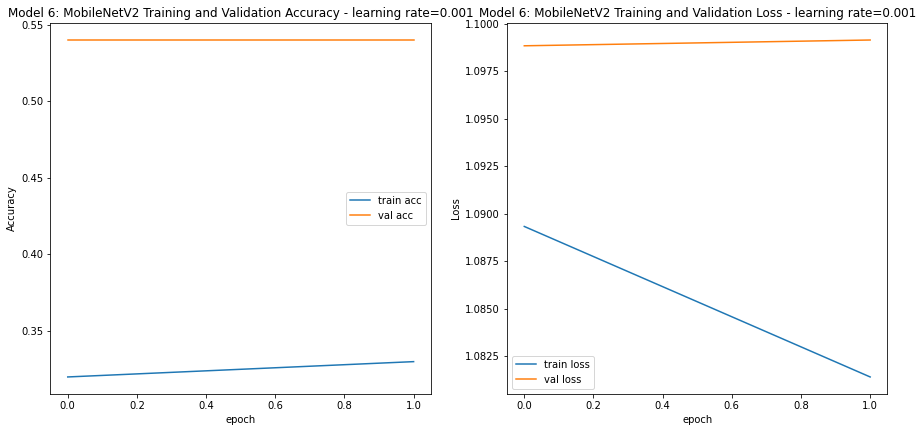

In [64]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(history6.history['acc'], label='train acc')
plt.plot(history6.history['val_acc'], label='val acc')
plt.title('Model 6: MobileNetV2 Training and Validation Accuracy - learning rate=0.001')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history6.history['loss'], label='train loss')
plt.plot(history6.history['val_loss'], label='val loss')
plt.title('Model 6: MobileNetV2 Training and Validation Loss - learning rate=0.001')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [65]:
print('Model 6 - Transfer Learning Using MobileNetV2 - learning_rate = 0.001')
print('Median Training Accuracy: ', np.median(history6.history['acc']))
print('Standard Deviation Training Loss: ', np.std(history6.history['loss']))
print('Median Validation Accuracy: ', np.median(history6.history['val_acc']))
print('Standard Deviation Validation Loss: ', np.std(history6.history['val_loss']))

Model 6 - Transfer Learning Using MobileNetV2 - learning_rate = 0.001
Median Training Accuracy:  0.32500000298023224
Standard Deviation Training Loss:  0.003963291645050049
Median Validation Accuracy:  0.5400000214576721
Standard Deviation Validation Loss:  0.00015217065811157227


In [66]:
model6.save('models/model6-mobilenetv2')

In [67]:
model6.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dense_36 (Dense)            (None, 7, 7, 3)           3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


[Return to TOC](#toc)

### Transfer Learning with [Xception](https://keras.io/api/applications/xception/)

In [ ]:
#preprocess_input = tf.keras.applications.xception.preprocess_input
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [73]:
# Create the base model from the pre-trained model Xception
pretrained_model2 = tf.keras.applications.Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                                                   include_top=False,
                                                   weights='imagenet')
pretrained_model2.trainable = False
pretrained_model2.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [74]:
model7 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)),
                         input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]),
    pretrained_model2,
    tf.keras.layers.Dense(len(num_train_classes), activation='softmax')
])

In [75]:
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               metrics=['acc'])

In [76]:
history7 = model.fit(train_generator,
                     steps_per_epoch=STEP_SIZE,
                     epochs=EPOCHS,
                     batch_size=10,
                     validation_data=validation_generator,
                     validation_steps=STEP_SIZE,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

Epoch 1/10
10/10 [==============================] - 2s 157ms/step - loss: 1.0817 - acc: 0.3400 - val_loss: 1.1012 - val_acc: 0.1400
Epoch 2/10
10/10 [==============================] - 2s 161ms/step - loss: 1.0818 - acc: 0.4271 - val_loss: 1.1026 - val_acc: 0.1400


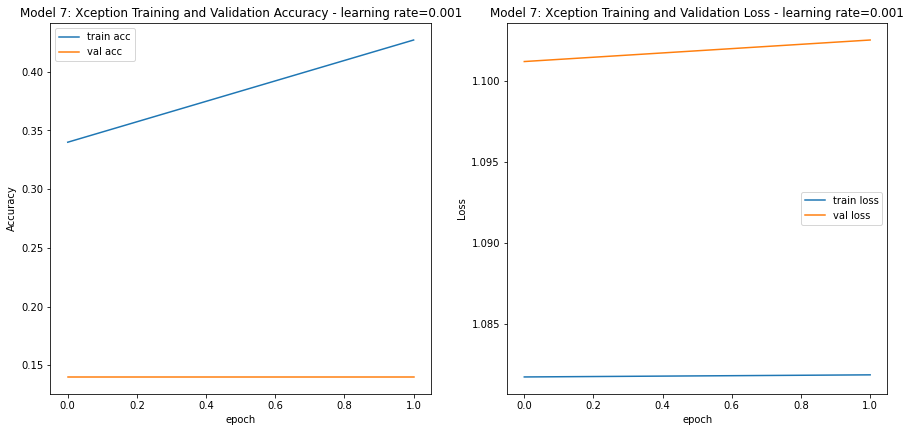

In [77]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(history7.history['acc'], label='train acc')
plt.plot(history7.history['val_acc'], label='val acc')
plt.title('Model 7: Xception Training and Validation Accuracy - learning rate=0.001')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history7.history['loss'], label='train loss')
plt.plot(history7.history['val_loss'], label='val loss')
plt.title('Model 7: Xception Training and Validation Loss - learning rate=0.001')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [78]:
model7.save('models/model7-xception')

In [79]:
model7.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dense_37 (Dense)            (None, 7, 7, 3)           6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________


<a class='anchor' id='evalmodels'></a>
## Model Evaluation and Selection

<a class='anchor' id='eval'></a>
### Evaluate the Models
How do the various models stack up based on the median accuracy of the ***validation*** data:

In [80]:
# Compare the various models based on the validation scores
data3 = {
    'model_nm':['Transfer Learning MobileNetV2', 'Transfer Learning Xception'],
    'median_train_acc':[np.median(history6.history['acc']), np.median(history7.history['acc'])],
    'std_dev_train_loss':[np.std(history6.history['loss']), np.std(history7.history['loss'])],
    'median_val_acc':[np.median(history6.history['val_acc']), np.median(history7.history['val_acc'])],
     'std_dev_val_loss':[np.std(history6.history['val_loss']), np.std(history7.history['val_loss'])]
    }
    
df3 = pd.DataFrame(data3) 

In [81]:
dfs = [df, df2, df3]
eval_val_df = pd.concat(dfs, axis=0, ignore_index=True)
eval_val_df.sort_values('median_val_acc', ascending=False)

,model_nm,median_train_acc,std_dev_train_loss,median_val_acc,std_dev_val_loss
10,SGD - dropout = 0.2,0.625000,0.230028,0.730,0.181499
13,Adam with more Conv2D layers,0.555000,0.116325,0.620,0.132242
11,SGD - dropout = 0.5,0.540833,0.265785,0.605,0.082236
3,SGD - learning rate = 0.01,0.530000,0.138835,0.600,0.094126
15,Adam with more Conv2D and Dense layers,0.555000,0.138829,0.570,0.108256
7,Adam - learning rate = 0.01,0.489792,4.431596,0.560,0.025022
9,SGD - dropout = 0.0,0.418333,0.012612,0.540,0.006482
2,SGD - learning rate = 0.001,0.405000,0.010283,0.540,0.002131
4,SGD - learning rate = 0.1,0.395000,1.157958,0.540,0.047417
17,Transfer Learning MobileNetV2,0.325000,0.003963,0.540,0.000152


[Return to TOC](#toc)

<a class='anchor' id='preprocesstest'></a>
### Pre-Process the Test Data

In [82]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

Found 171 images belonging to 3 classes.


In [83]:
#https://stackoverflow.com/questions/68305559/cnn-splitting-train-test-and-validation-and-saving-training-progress
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, 
                                  validation_split=0.0).flow_from_directory(test_dir, 
                                                                            target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                                                         batch_size=BATCH_SIZE)

Found 171 images belonging to 3 classes.


[Return to TOC](#toc)

<a class='anchor' id='evaltest'></a>
### Evaluate Model on the Test Data

Now lets evaluate on the test data.

In [84]:
eval1 = model1.evaluate(test_generator)

18/18 [==============================] - 1s 32ms/step - loss: 1.2597 - acc: 0.1930


In [85]:
eval2 = model2.evaluate(test_generator)

18/18 [==============================] - 4s 229ms/step - loss: 1.1343 - acc: 0.2456


In [86]:
eval3 = model3.evaluate(test_generator)

18/18 [==============================] - 4s 237ms/step - loss: 1.1665 - acc: 0.1988


In [87]:
eval4 = model4.evaluate(test_generator)

18/18 [==============================] - 4s 241ms/step - loss: 1.1255 - acc: 0.1871


In [88]:
eval5 = model5.evaluate(test_generator)

18/18 [==============================] - 5s 261ms/step - loss: 1.1854 - acc: 0.1287


In [89]:
# this was the best of the tuned models
reconstructed_model = models.load_model("models/model1-base-SGD-dropout-0.8")

In [90]:
reconstructed_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 394272)            0         
                                                                 
 dense_24 (Dense)            (None, 6)                 2365638   
                                                                 
 dropout_3 (Dropout)         (None, 6)                 0         
                                                                 
 dense_25 (Dense)            (None, 3)                 21        
                                                     

In [91]:
eval_1a = reconstructed_model.evaluate(test_generator)

18/18 [==============================] - 1s 36ms/step - loss: 1.1206 - acc: 0.3333


In [94]:
# there seems to be an issue with the shapes of my objects
# ValueError: Shapes (None, None) and (None, 7, 7, 3) are incompatible
# if we have time we will come back and debug
#model6.evaluate(test_batches)

In [95]:
# there seems to be an issue with the shapes of my objects
# ValueError: Shapes (None, None) and (None, 7, 7, 3) are incompatible
# if we have time we will come back and debug
#model7.evaluate(test_batches)

In [96]:
# Compare the various models based on the test data (skipping the transfer learning models for now)
eval_test_data = {
    'model_nm':['SGD - learning rate = 0.2, momentum = 0.8', 'Adam with more Conv2D layers',
                'SGD with more Conv2D layers', 'Adam with more Conv2D and Dense layers',
                'SGD with more Conv2D and Dense layers', 'SGD - dropout = 0.8'],
    'test_acc':[eval1[1], eval2[1], eval3[1], eval4[1], eval5[1], eval_1a[1]],
    'test_loss':[eval1[0], eval2[0], eval3[0], eval4[0], eval5[0], eval_1a[0]]
    }
    
eval_test_df = pd.DataFrame(eval_test_data) 

In [97]:
# eval_test_df.sort_values('acc', ascending=False) # there are duplicates in the test_acc
eval_test_df

,model_nm,test_acc,test_loss
0,"SGD - learning rate = 0.2, momentum = 0.8",0.192982,1.259703
1,Adam with more Conv2D layers,0.245614,1.134341
2,SGD with more Conv2D layers,0.198830,1.166530
3,Adam with more Conv2D and Dense layers,0.187135,1.125454
4,SGD with more Conv2D and Dense layers,0.128655,1.185385
5,SGD - dropout = 0.8,0.333333,1.120617


**Observations:**
I have noticed that each time, we run the code, different models could have the highest accuracy. So next time this is re-run, we might get a different best model.

In the last run, based on the highest test accuracy, it looks like the **Model 2: Adam optimizer with more Convolutional 2D layers** performed the best.  We will use this model for deployment piece, even if a future run of a different model shows improvement so we can demonstrate deployment skills.

**Our script train.py will create and train Model 2 Adam optimizer with more Convolutional 2D layers and convert it to a tflite model for deployment.**

If we had more time, we might try additional tuning, perhaps using the keras_tuner, and maybe some ensembling techniques.

***Note: Due to the stochastic nature of neural nets, your results may differ.***

### Testing on a Sample Image

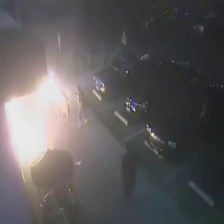

In [98]:
path = 'data/img_data/test/fire/img_120.jpg'
img = load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
display(img)

In [99]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [100]:
pred = model2.predict(X)

In [101]:
dict(zip(class_nms, pred[0]))

{'normal': 0.015803088, 'fire': 0.968757, 'smoke': 0.015439975}

It looks like fire in the picture and the model identified fire.

**Observations:**
Our overall accuracy on the test data was not particulary good, just 0.37.  This may be due to several reasons:
* small data set to train on
* many more parameters that could be tuned
* could experiment with different layers

Now on to the deployment.

[Return to TOC](#toc)

<a class='anchor' id='conclusion'></a>
## Conclusion

* Use more images for training
* Remove backgrounds from images
* Try tuning other hyperparameters for the models, perhaps try keras_tuner.  There are so many possibilites we could have tried if we had more time
* Try experimenting with the layers, filters, strides, and padding more
* Debug why the shape issue when evaluating the transfer models on test data
* Try using the video images
* Work with satellite images and geolocation information for fire detection

<a class='anchor' id='references'></a>
## References 
*Because there's a lot to learn about Deep Learning and Neural Nets and I couldn't do this without standing on the shoulders of giants.  Thank you!*

https://keras.io/api/

https://keras.io/getting_started/faq/

https://faroit.com/keras-docs/1.2.2/scikit-learn-api/

https://data-flair.training/blogs/keras-convolution-neural-network/

https://towardsdatascience.com/explained-deep-learning-in-tensorflow-chapter-1-9ab389fe90a1

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/

https://medium.com/geekculture/max-pooling-why-use-it-and-its-advantages-5807a0190459

https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

https://data-flair.training/blogs/keras-convolution-neural-network/

https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d

https://imaddabbura.github.io/post/gradient-descent-algorithm/

https://medium.com/analytics-vidhya/this-blog-post-aims-at-explaining-the-behavior-of-different-algorithms-for-optimizing-gradient-46159a97a8c1

https://mlfromscratch.com/optimizers-explained/

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

https://www.jeremyjordan.me/nn-learning-rate/

https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed

https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

https://machinelearningmastery.com/different-results-each-time-in-machine-learning/

https://www.analyticsvidhya.com/blog/2021/08/quick-start-with-tensorflow-callbacks/

https://nusit.nus.edu.sg/services/hpc-newsletter/deep-learning-best-practices-checkpointing-deep-learning-model-training/

https://machinelearningmastery.com/check-point-deep-learning-models-keras/

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras

https://www.tensorflow.org/tutorials/images/transfer_learning

https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

https://github.com/stephenleo/keras-model-selection/blob/main/keras_model_selection.ipynb

https://keras.io/guides/keras_tuner/getting_started/

FireNet: A Specialized Lightweight Fire & Smoke Detection Model for Real-Time IoT Applications
(https://arxiv.org/pdf/1905.11922.pdf)

[Return to TOC](#toc)